In [1]:
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycox.datasets import metabric
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold

In [2]:
s = 1

In [3]:
# data -> cv + val
# cv - 5 folds stratified by y and time bin

# hp search:
#     for every cv fold:
#         fit on all cv folds except this fold
#         save quality on val
# select the best parameters by val quality

# train and evaluate model with best parameters in 5fold CV (train on 4, test on one) - out average


# As the four data sets are somewhat small, we scored our fitted models using 5-fold cross-
# validation, where the hyperparameter search was performed individually for each fold. For
# all the neural networks, we performed a random hyperparameter search over 300 parameter
# configurations and chose the model with the best score on a held-out validation set.
# we sample 300 random parameter configurations for each method,
# for each fold of each data set
# Table 2 shows the time-dependent concordance, or C td , averaged over the five cross-
# validation folds.

#### METABRIC

In [3]:
df_all = metabric.read_df()

In [4]:
df_all.describe()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
count,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000
mean,6.210830,6.237199,10.765366,5.872822,0.616597,0.597164,0.207983,0.758929,61.087112,125.025055,0.579307
std,0.862968,1.020872,1.357359,0.341254,0.486344,0.490591,0.405970,0.427844,12.978707,76.334206,0.493800
min,5.158794,4.860645,6.372949,5.101093,0.000000,0.000000,0.000000,0.000000,21.930000,0.000000,0.000000
25%,5.692096,5.408728,9.969681,5.622290,0.000000,0.000000,0.000000,1.000000,51.375001,60.824999,0.000000
50%,5.949283,5.877591,10.530301,5.816998,1.000000,1.000000,0.000000,1.000000,61.769999,114.900002,1.000000
75%,6.458780,6.899220,11.159306,6.058293,1.000000,1.000000,0.000000,1.000000,70.592497,184.474995,1.000000
max,14.443632,9.932116,14.643900,7.658863,1.000000,1.000000,1.000000,1.000000,96.290001,355.200012,1.000000


In [7]:
df_all = df_all[df_all['duration'] != 0]

In [8]:
cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

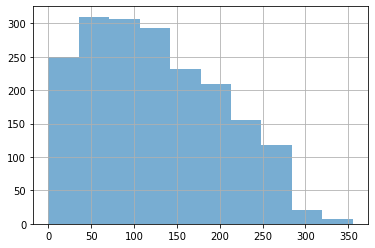

In [9]:
df_all['duration'].hist(alpha=0.6);

In [10]:
quan = np.arange(0, 1, 0.2)
bins = df_all['duration'].quantile(quan).values
bins = np.append(bins, np.inf)
df_all['duration_bin'] = pd.cut(df_all['duration'], bins=bins, labels=np.arange(0, 5, 1))
df_all['strata'] = df_all['event'].astype(str) + "_" + df_all['duration_bin'].astype(int).astype(str)

/home/islam/anaconda3/envs/pycox/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/islam/anaconda3/envs/pycox/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [11]:
df_all['strata'].value_counts(dropna=False).sort_index()

0_0                        45
0_1                       110
0_2                       181
0_3                       211
0_4                       253
1_-9223372036854775808      1
1_0                       335
1_1                       270
1_2                       200
1_3                       170
1_4                       127
Name: strata, dtype: int64

In [12]:
df_all = df_all[df_all['strata'] != '1_-9223372036854775808']

In [13]:
df_all['strata'].value_counts(dropna=False).sort_index()

0_0     45
0_1    110
0_2    181
0_3    211
0_4    253
1_0    335
1_1    270
1_2    200
1_3    170
1_4    127
Name: strata, dtype: int64

In [14]:
# get validation data
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1)
df_all.reset_index(drop=True, inplace=True)
for tr_i, te_i in sss.split(df_all, df_all['strata']):
    # split
    df_val = df_all.iloc[te_i, ]
    df_cv = df_all.iloc[tr_i, ]
    # preprocess val
    m = df_cv[cols_standardize].mean()
    v = df_cv[cols_standardize].std()
    df_val_tr = df_val.copy(deep=True)
    for idx, col in enumerate(cols_standardize):
        df_val_tr[col] = df_val_tr[col] - m.values[idx]
        df_val_tr[col] = df_val_tr[col] / v.values[idx]
    x_val = df_val_tr[cols_standardize + cols_leave].values
    y_val = df_val_tr['event'].values
    t_val = df_val_tr['duration'].astype(int).values

In [15]:
# get cv data
df_cv_data = dict()
df_cv.reset_index(drop=True, inplace=True)
sf = StratifiedKFold(n_splits=5, random_state=1)
for i, (tr_i, te_i) in enumerate(sf.split(df_cv, df_cv['strata'])):
    # split
    df_train = df_cv.iloc[tr_i, ]
    df_test = df_cv.iloc[te_i, ]
    # preprocess
    m = df_train[cols_standardize].mean()
    v = df_train[cols_standardize].std()
    for idx, col in enumerate(cols_standardize):
        df_train[col] = df_train[col] - m.values[idx]
        df_train[col] = df_train[col] / v.values[idx]
        df_test[col] = df_test[col] - m.values[idx]
        df_test[col] = df_test[col] / v.values[idx]
    df_cv_data[i] = {
        'test': {
            'x': df_test[cols_standardize + cols_leave].values,
            'y': df_test['event'].values,
            't': df_test['duration'].astype(int).values 
        },
        'train': {
            'x': df_train[cols_standardize + cols_leave].values,
            'y': df_train['event'].values,
            't': df_train['duration'].astype(int).values 
        }
    }

/home/islam/anaconda3/envs/pycox/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/islam/anaconda3/envs/pycox/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/islam/anaconda3/envs/pycox/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [16]:
data = {
    'val': {
        'x': x_val,
        'y': y_val,
        't': t_val
    },
    'cv': df_cv_data
}

with open('../data/metabric_cv.pkl', 'wb') as f:
    pickle.dump(data, f)